In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

## Connection to the cassandra cluster

In [141]:
from cassandra.cluster import Cluster
import datetime as dt
host = 'ec2-54-236-222-162.compute-1.amazonaws.com'
cluster = Cluster(contact_points=[host])
session = cluster.connect('wikistats')

ERROR:cassandra.connection:Closing connection <AsyncoreConnection(4579146640) ec2-54-236-222-162.compute-1.amazonaws.com:9042> due to protocol error: code=000a [Protocol error] message="Invalid or unsupported protocol version: 4"
Traceback (most recent call last):
  File "cassandra/cluster.py", line 1787, in cassandra.cluster.Session.add_or_renew_pool.run_add_or_renew_pool (cassandra/cluster.c:30488)
    new_pool = HostConnection(host, distance, self)
  File "cassandra/pool.py", line 295, in cassandra.pool.HostConnection.__init__ (cassandra/pool.c:6160)
    self._connection = session.cluster.connection_factory(host.address)
  File "cassandra/cluster.py", line 789, in cassandra.cluster.Cluster.connection_factory (cassandra/cluster.c:9245)
    return self.connection_class.factory(address, self.connect_timeout, *args, **kwargs)
  File "cassandra/connection.py", line 306, in cassandra.connection.Connection.factory (cassandra/connection.c:5139)
    conn = cls(host, *args, **kwargs)
  File "

## retrieving needed data for a specific hour and packaging it in a pandas DataFrame

In [142]:
def list_to_caslist(title_list):
    res = '(\''+title_list[0]+'\''
    for title in title_list[1:]:
        res+= ',\''+title+'\''
    res+=')'
    return res

In [143]:
str_time ='2011-02-01 06:00:00'
str_cmd = 'select * from wikistats.top100rising where event_time = \'%s\'' % str_time

def df_cql_to_panda(str_time):
    str_cmd = 'select * from wikistats.top100rising where event_time = \'%s\'' % str_time
    rows = session.execute(str_cmd)
    data = []
    columns = rows.column_names
    for row in rows:
        data.append([row.event_time, row.title, row.pageviews])    
    df = pd.DataFrame(data= data, columns=rows.column_names)
    df.sort_values('pageviews', inplace=True)
    return df
def df_h_cql_to_panda(str_time, title_list):
    str_cmd = 'select * from wikistats.top100risinghist where refhour = \'%s\' and title in %s ALLOW FILTERING' \
                % (str_time, list_to_caslist(title_list))
    rows = session.execute(str_cmd)
    data = []
    columns = rows.column_names
    for row in rows:
        data.append([row.refhour, row.title, row.event_time, row.pageviews])    
    if len(data) > 0:
        df = pd.DataFrame(data= data, columns=rows.column_names)
        df.sort_values('event_time', inplace=True)
        return df    

## defining visualization plots in matplotlib 

In [154]:
def dataviz_rising(str_time, n=100):
    df = df_cql_to_panda(str_time)
    dfh = df_h_cql_to_panda(str_time, df.title.values)
    plt.close('all')
    fig = plt.figure(figsize=(16,round(n*32/20.0)))
    plt.title('TOP %d Rising %s' % (n, str_time), fontsize='xx-large')
    ax = fig.add_subplot(1,2,1)
    x = df.title.values[-n:]
    y = df.pageviews.values[-n:]
    height = 0.75
    ax.barh(np.arange(len(y[:n])), y[:n], height , color = 'red', label = x)
    ax.set_yticks(np.arange(len(y[:n])))
    # Now make some labels
    labels = [ x[i] + ': %d views' % y[i] for i in range(n)]
    rects = ax.patches
    for rect, label in zip(rects, labels):
        width = rect.get_width()
        height = rect.get_height()
        ax.text(width/10, rect.get_y() + height / 2, label, ha='left', va='center', fontsize='xx-large' )
    #plotting trend history
    for i in range(0,n):
        ax = fig.add_subplot(n,2,2+i*2)
        y = dfh[dfh.title == x[i]].pageviews.values
        plt.fill_between(range(len(y)), 0, y, facecolor='orange', alpha=0.5)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    #plt.setp(ltext, fontsize='big') 
    plt.tight_layout()
    plt.savefig('TOP_%d_Rising_%s.png' % (n,str_time))
    plt.show()
    return

## retrieving needed data for a specific date and packaging it in a pandas DataFrame

In [145]:
date_str = '2011-03-03'
def dft_cql_to_panda(str_time):
    str_cmd = 'select * from wikistats.top100trending where event_time = \'%s\'' % pd.to_datetime(str_time)
    rows = session.execute(str_cmd)
    data = []
    columns = rows.column_names
    for row in rows:
        data.append([row.event_time, row.title, row.pageviews])    
    df = pd.DataFrame(data= data, columns=rows.column_names)
    df.sort_values('pageviews', inplace=True)
    return df
def dft_h_cql_to_panda(str_time, title_list):
    str_cmd = 'select * from wikistats.top100trendinghist where refhour = \'%s\' and title in %s ALLOW FILTERING' \
                % (pd.to_datetime(str_time), list_to_caslist(title_list))
    rows = session.execute(str_cmd)
    data = []
    columns = rows.column_names
    for row in rows:
        data.append([row.refhour, row.title, row.event_time, row.pageviews])    
    if len(data) > 0:
        df = pd.DataFrame(data= data, columns=rows.column_names)
        df.sort_values('event_time', inplace=True)
        return df    

## defining visualization plots in matplotlib

In [152]:
def dataviz_trending(str_time, n=100):
    df = dft_cql_to_panda(str_time)
    dfh = dft_h_cql_to_panda(str_time, df.title.values)
    plt.close('all')
    fig = plt.figure(figsize=(16,round(n*32/20.0)))
    plt.title('TOP %d Trending %s' % (n, str_time), fontsize='xx-large')
    ax = fig.add_subplot(1,2,1)
    x = df.title.values[-n:]
    y = df.pageviews.values[-n:]
    height = 0.75
    ax.barh(np.arange(len(y[:n])), y[:n], height , color = 'red', label = x)
    ax.set_yticks(np.arange(len(y[:n])))
    # Now make some labels
    labels = [ x[i] + ': %d views' % y[i] for i in range(n)]
    rects = ax.patches
    for rect, label in zip(rects, labels):
        width = rect.get_width()
        height = rect.get_height()
        ax.text(width/10, rect.get_y() + height / 2, label, ha='left', va='center', fontsize='xx-large')
    #plotting trend history
    for i in range(0,n):
        ax = fig.add_subplot(n,2,2+i*2)
        y = dfh[dfh.title == x[i]].pageviews.values
        plt.fill_between(range(len(y)), 0, y, facecolor='orange', alpha=0.5)
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
    plt.tight_layout()
    plt.savefig('TOP_%d_Trending_%s.png' % (n,str_time))
    plt.show()
    return

# Examples

## TOP 100 trending 14/03/2011

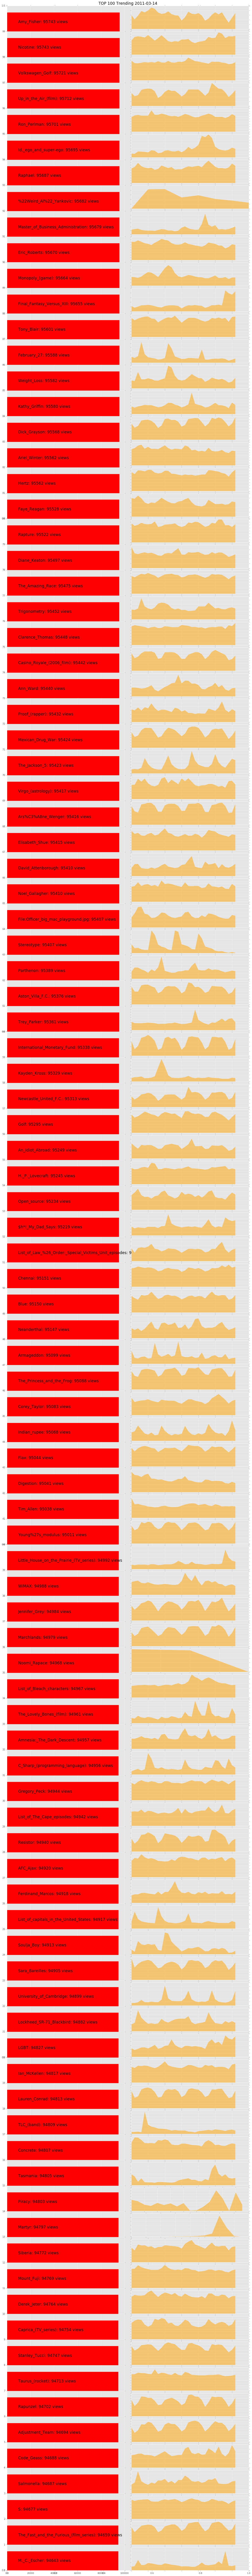

In [153]:
#example
date = '2011-03-14'
dataviz_trending(date)

## TOP 100 rising 10:00 on 14/03/2011

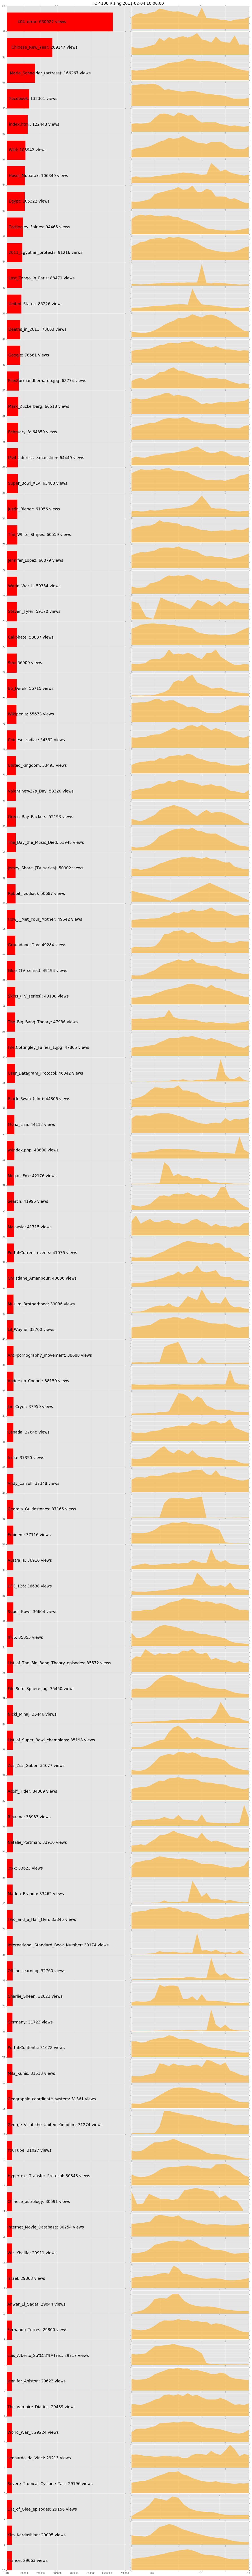

In [155]:
#example
hour ='2011-02-04 10:00:00'
dataviz_rising(hour, n=100)

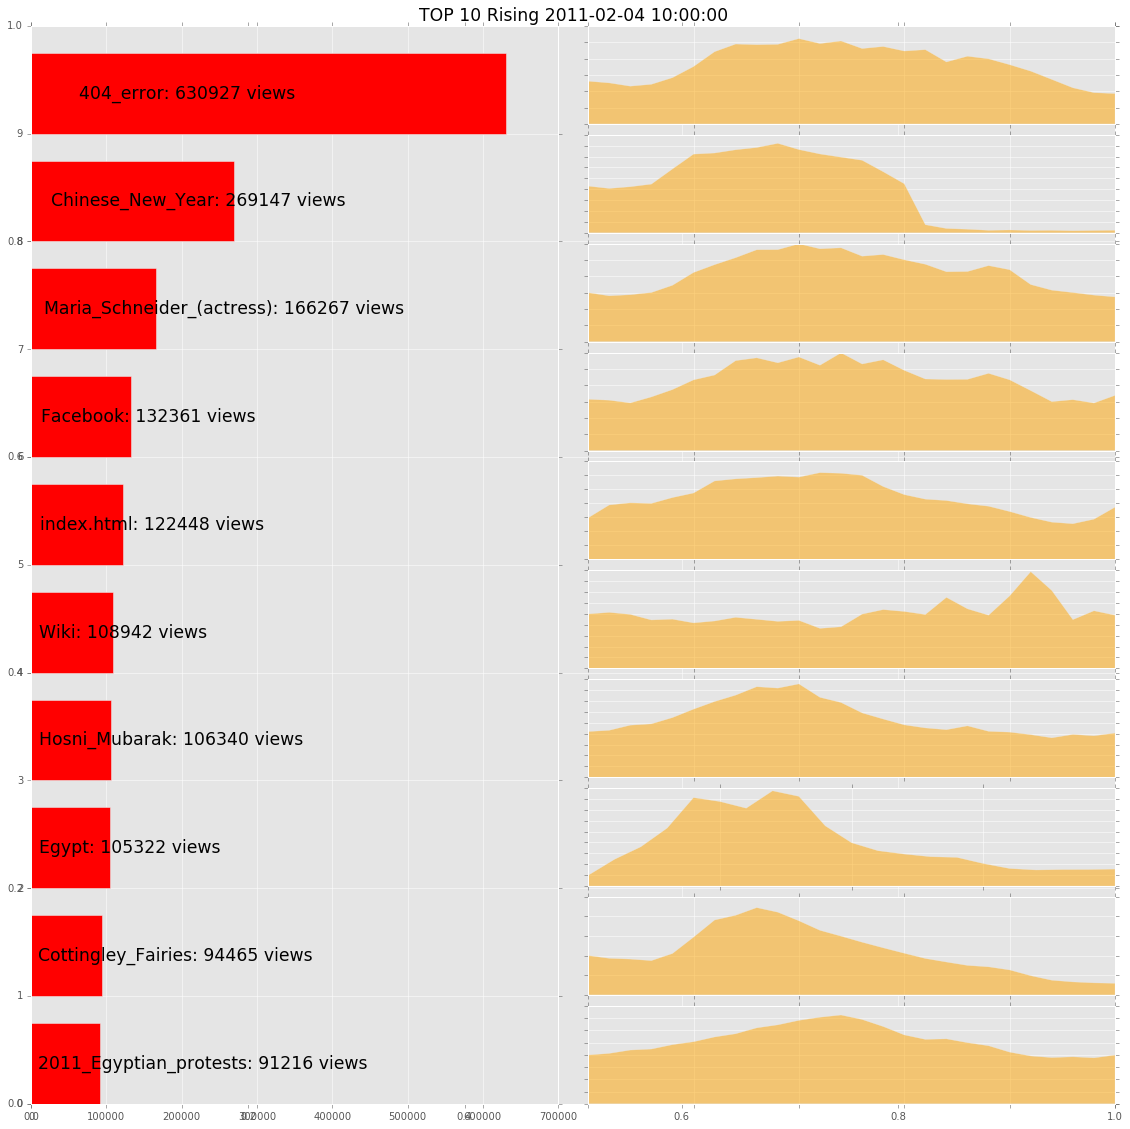

Traceback (most recent call last):
  File "/Users/galicher/anaconda/envs/python27/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
  File "/Users/galicher/anaconda/envs/python27/lib/python2.7/site-packages/ipykernel/iostream.py", line 216, in write
    self._buffer.write(string)
ValueError: I/O operation on closed file
Logged from file thread.py, line 55
Traceback (most recent call last):
  File "cassandra/connection.py", line 983, in cassandra.connection.ConnectionHeartbeat.run (cassandra/connection.c:22959)
    f.wait(self._interval)
  File "cassandra/connection.py", line 925, in cassandra.connection.HeartbeatFuture.wait (cassandra/connection.c:21416)
    raise OperationTimedOut()
OperationTimedOut: errors=None, last_host=None
Traceback (most recent call last):
  File "cassandra/connection.py", line 983, in cassandra.connection.ConnectionHeartbeat.run (cassandra/connection.c:22959)
    f.wait(self._interval)
  File "cassandra/connection.py", line 925, 

In [156]:
#other example
hour ='2011-02-04 10:00:00'
dataviz_rising(hour, n=10)